# Baseline for ORIENTME Challenge on AIcrowd
#### Author : Sharada Mohanty

## Download Necessary Packages

In [1]:
import sys

## Download data
The first step is to download the training data and the test data


In [2]:
# #Donwload the datasets
#!rm -rf data/
#!mkdir data/

#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/training.tar.gz -O data/training.tar.gz
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/test.tar.gz -O data/test.tar.gz
#!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/orientme/v0.1/sample_submission.csv -O data/sample_submission.csv
#!tar xvzf data/training.tar.gz -C data/
#!tar xvzf data/test.tar.gz -C data/

In [3]:
## Now the data is available at the following locations:

TRAINING_IMAGES_FOLDER = "data/training/images/"
TRAINING_LABELS_PATH = "data/training/labels.csv"
TEST_IMAGES_FOLDER = "data/images"
SAMPLE_SUBMISSION_FILE_PATH = "data/sample_submission.csv"


## Import packages

In [4]:
import os
import tqdm

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error
import skimage
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image 


## Load Data
We use PIL library to load our images. Here we are creating our array where our input features are the mean colours and output features are the rotations along the 3 axis.

In [5]:
training_labels_df = pd.read_csv(TRAINING_LABELS_PATH)

def pre_process_data_X(image):
    """
    This file takes a loaded image and returns a particular 
    representation of the data point
    
    
    NOTE: This current baseline implements a **very** silly approach
    of representing every image by the mean RGB values for every image.
    
    You are encourage to try to alternate representations of the data,
    or figure out how to learn the best representation from the data ;)
    """
    image = image.resize((64,64))
    im_array = np.array(image)
    return im_array
    #mean_rgb = im_array.mean(axis=(0, 1))
    #return mean_rgb


ALL_DATA = []

for _idx, row in tqdm.tqdm(training_labels_df.iterrows(), total=training_labels_df.shape[0]):
    filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        row.filename
    )
    im = Image.open(filepath)
    
    data_X = pre_process_data_X(im)
    data_Y = [row.xRot, row.yRot, row.zRot]
    
    ALL_DATA.append((data_X, data_Y))
    #if _idx == 10000:
    #    break



100%|██████████| 50000/50000 [02:33<00:00, 325.49it/s]


50000it [00:02, 21984.25it/s]
50000it [00:02, 21953.89it/s]
50000it [00:02, 20887.79it/s]
50000it [00:02, 21304.47it/s]
50000it [00:02, 21801.85it/s]
50000it [00:02, 21726.08it/s]
50000it [00:02, 21233.33it/s]
50000it [00:02, 21629.55it/s]


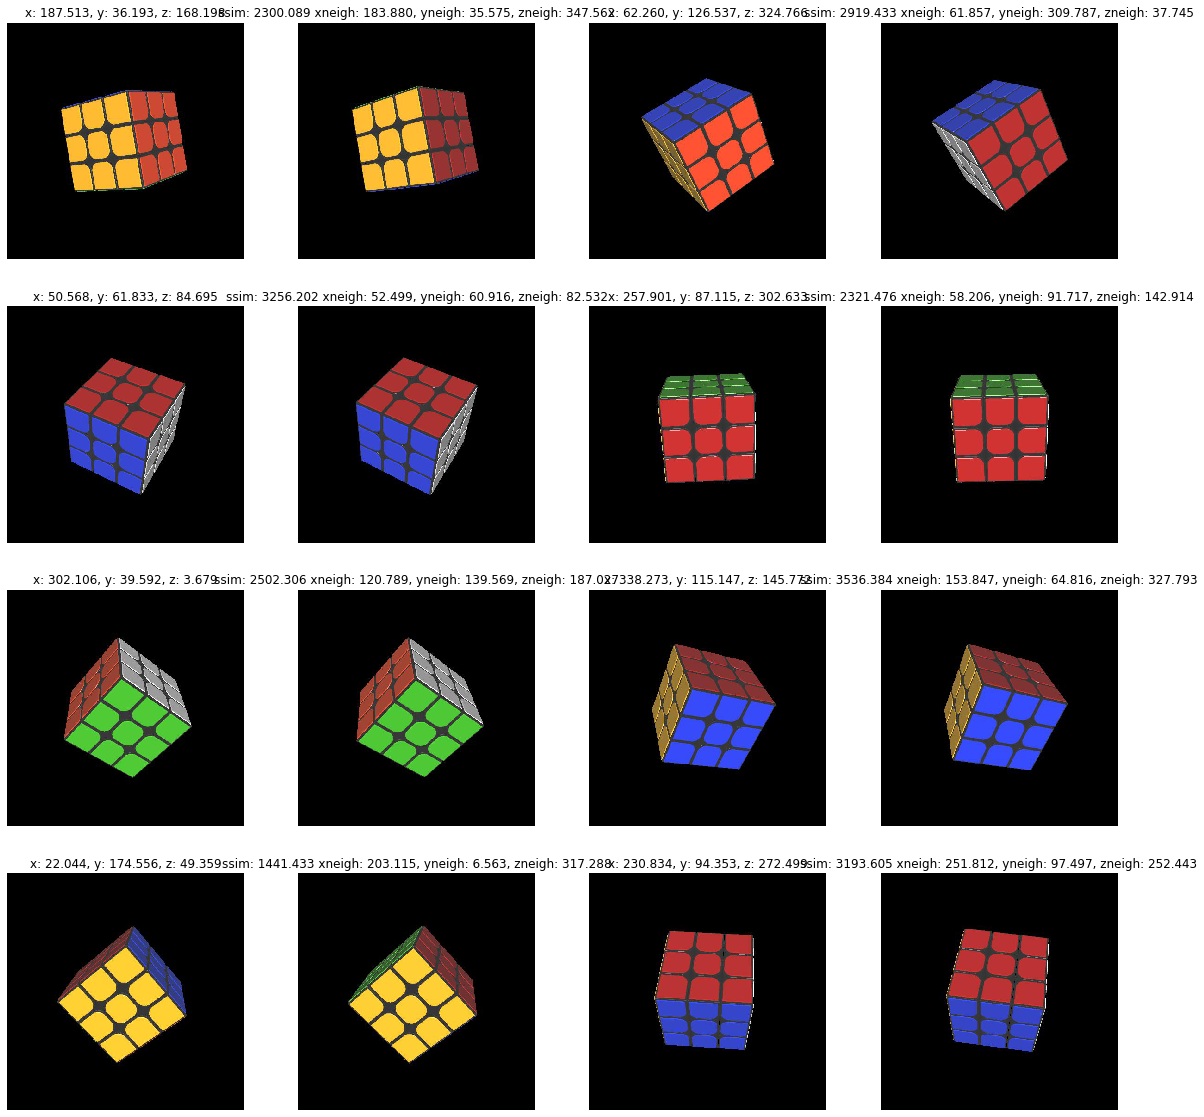

In [6]:
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_mse as mse

plt.figure(figsize=(20,20))
for i in range(8):
    path,x,y,z = training_labels_df.iloc[i]
    filepath = os.path.join(
          TRAINING_IMAGES_FOLDER,
          path
          )
    img = Image.open(filepath)
    im = ALL_DATA[i][0]

    #Search neighbour
    min_dist = np.inf
    best_idx = -1
    for _idx, (im_temp, label) in tqdm.tqdm(enumerate(ALL_DATA)):
        if _idx == i:
            continue
        #if _idx == 10000:
        #    break

        dist = mse(im, im_temp)#, multichannel=True)
        #dist = 1 - ssim(im, im_temp, multichannel=True)
        if dist < min_dist:
            best_idx = _idx
            min_dist = dist
    
    path_neigh,xneigh,yneigh,zneigh = training_labels_df.iloc[best_idx]
    filepath = os.path.join(
            TRAINING_IMAGES_FOLDER,
            path_neigh
            )
    img_neigh = Image.open(filepath)

    plt.subplot(4,4,2*i+1)
    plt.axis('off')
    plt.title("x: %.3f, y: %.3f, z: %.3f"%(x,y,z))
    plt.imshow(img)

    plt.subplot(4,4,2*i+2)
    plt.axis('off')
    plt.title("ssim: %.3f xneigh: %.3f, yneigh: %.3f, zneigh: %.3f"%(dist, xneigh,yneigh,zneigh))
    plt.imshow(img_neigh)

plt.show()

## EDA
We now see the kind of images the dataset contains to get a better idea. The title signifies clockwise rotation of the cube along that axis

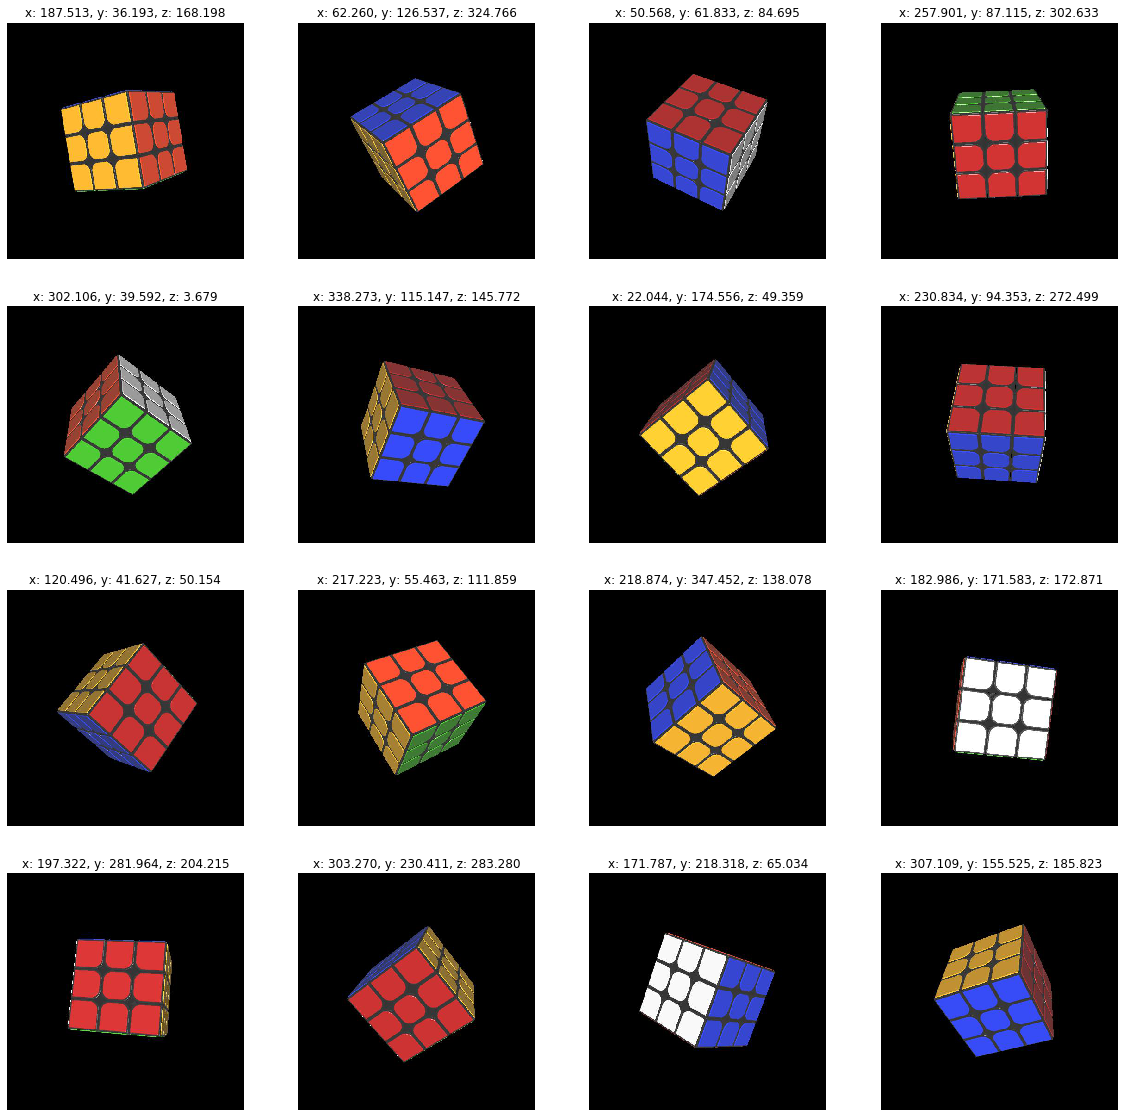

In [7]:
plt.figure(figsize=(20,20))
for i in range(16):
  path,x,y,z = training_labels_df.iloc[i]
  filepath = os.path.join(
        TRAINING_IMAGES_FOLDER,
        path
    )
  im = Image.open(filepath)
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.title("x: %.3f, y: %.3f, z: %.3f"%(x,y,z))
  plt.imshow(im)

## Split Data into Train and Validation
We split the dataset into Training data and Validation datasets to help us test the generalizability of our models, and to ensure that we are not overfitting on the training set.

In [8]:
training_set, validation_set= train_test_split(ALL_DATA, test_size=0.2, random_state=42) 

Here we have selected the size of the testing data to be 20% of the total data. You can change it and see what effect it has on the accuracies. To learn more about the train_test_split function [click here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).

Now, since we have our data splitted into train and validation sets, we need to get the label separated from the data.

In [9]:
X_train, y_train = zip(*training_set)
X_val, y_val = zip(*validation_set)
X_train_full, y_train_full = zip(*ALL_DATA)


X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], -1)
X_train_full = np.array(X_train_full)
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1)
y_train = np.array(y_train)
y_train_full = np.array(y_train_full)
X_val = np.array(X_val)
X_val = X_val.reshape(X_val.shape[0], -1)
y_val = np.array(y_val)
print(X_train.shape)
print(y_train.shape)

(40000, 12288)
(40000, 3)


## Define the Classifier
Now we finally come to the juicy part. 
Now that all the data is all loaded and available nice, we can finally get to training the classifier. Here we use sklearn [`MLPRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) to train our network. We can tune the hyper parameters based on cross validation scores 

In [10]:
def find_nn(img, train_set):

    #Search neighbour
    min_dist = np.inf
    best_idx = -1
    for _idx, im_temp in enumerate(train_set):

        dist = mse(img, im_temp)#, multichannel=True)
        #dist = 1 - ssim(im, im_temp, multichannel=True)
        if dist < min_dist:
            best_idx = _idx
            min_dist = dist
    
    return best_idx

from sklearn.neighbors import KNeighborsRegressor
model = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
model.fit(X_train, np.ones(X_train.shape[0]))

#pred = []
#tot_loss = 0.0
#for img, real_y in tqdm.tqdm(zip(X_val, y_val)):
#    best_match_idx = find_nn(img, X_train)
#    pred.append(y_train[best_match_idx])
#    tot_loss += mean_squared_error(real_y, y_train[best_match_idx])

#print("Total Loss: {}".format(tot_loss))

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                    weights='uniform')

In [16]:
idxs = model.kneighbors(X_val, return_distance = False)
y_preds = np.zeros((X_val.shape[0], 3))
for i, idx in enumerate(idxs):
    y_preds[i] = y_train[idx]

total_loss = mean_squared_error(y_val, y_preds)
print(total_loss)

16030.927122384885


In [17]:
#model_full = KNeighborsRegressor(n_neighbors=1, n_jobs=-1)
#model_full.fit(X_train_full, np.ones(X_train_full.shape[0]))

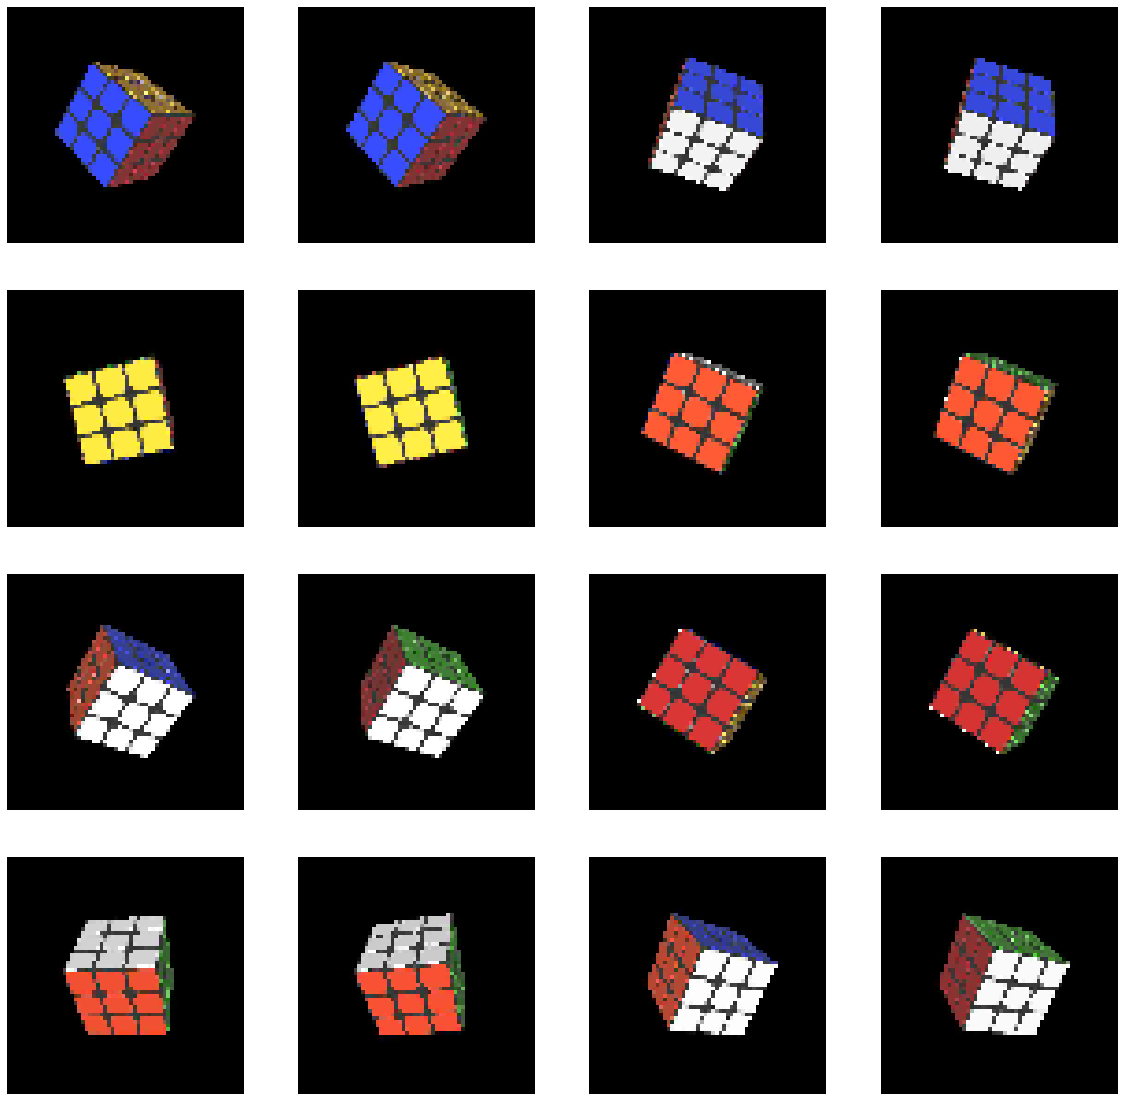

In [39]:
plt.figure(figsize=(20,20))
for i, y in enumerate(y_val[:8]):
    val_img = X_train_full[(y_train_full == y).sum(axis=1)==3]
    pred_img = X_train_full[(y_train_full==y_preds[i]).sum(axis=1)==3]
    plt.subplot(4,4,2*i+1)
    plt.axis('off')
    #plt.title("x: %.3f, y: %.3f, z: %.3f"%(x,y,z))
    plt.imshow(np.squeeze(val_img))

    plt.subplot(4,4,2*i+2)
    plt.axis('off')
    #plt.title("x: %.3f, y: %.3f, z: %.3f"%(x,y,z))
    plt.imshow(np.squeeze(pred_img))
plt.show()

## Load Test Set
Load the test data now

In [18]:
import glob

TEST_DATA = []
TEST_FILENAMES = []

for _test_image_path in tqdm.tqdm(glob.glob(os.path.join(TEST_IMAGES_FOLDER, "*.jpg"))):
    filename = os.path.basename(_test_image_path)
    im = Image.open(_test_image_path)
    
    data_X = pre_process_data_X(im)
    TEST_DATA.append(data_X)
    TEST_FILENAMES.append(filename)

100%|██████████| 50001/50001 [03:01<00:00, 275.62it/s]


In [19]:
TEST_DATA = np.array(TEST_DATA)
TEST_DATA = TEST_DATA.reshape(TEST_DATA.shape[0], -1)
# model = classifier

## Make predictions on the test set

In [2]:
test_predictions = np.array((TEST_DATA.shape[0], 3))
test_idxs = model.kneighbors(TEST_DATA, return_distance=False)
for i, idx in enumerate(test_idxs):
    test_predictions[i] = y_train[idx]

#test_idxs = model_full.kneighbors(TEST_DATA, return_distance=False)
#for idx in test_idxs:
#    test_predictions.append(y_train_full[idx])

#for img in tqdm.tqdm(TEST_DATA):
#    best_match_idx = find_nn(img, X_train_full)
#    test_predictions.append(y_train_full[best_match_idx])


NameError: name 'np' is not defined

In [1]:
print(test_predictions.shape)

NameError: name 'test_predictions' is not defined

In [ ]:
test_df = pd.DataFrame(test_predictions, columns=['xRot', 'yRot', 'zRot'])
test_df["filename"] = TEST_FILENAMES

## Save the prediction to csv

In [0]:
test_df.to_csv('submission.csv', index=False)

Note: Do take a look at the submission format.The submission file should contain a header.

## To download the generated csv in Google Colab run the below command

In [0]:
from google.colab import files
files.download('submission.csv')

### Go to [platform](https://www.aicrowd.com/challenges/aicrowd-blitz-may-2020/problems/orientme). Participate in the challenge and submit the submission.csv.